In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler , WeightedRandomSampler
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [150]:
# train = pd.read_csv('Data/train.csv')

In [151]:
# train_X = torch.from_numpy(np.array(train.drop('label',axis=1)))
# train_y = torch.from_numpy(np.array(train['label']))

In [152]:
# subset_idx = torch.cat((torch.arange(64),torch.arange(-train_X.shape[1],0)))

In [153]:
# class_sample_count = torch.tensor(
#     [(train_y[subset_idx] == t).sum() for t in torch.unique(train_y, sorted=True)])
# weight = 1. / class_sample_count.float()
# samples_weight = torch.tensor([weight[t] for t in train_y[subset_idx]])

In [154]:
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
# train_dataset = torch.utils.data.TensorDataset(
#     train_X[subset_idx], train_y[subset_idx])

In [155]:
# train_loader = DataLoader( train_dataset, batch_size=64, num_workers=1, sampler=sampler)

In [160]:
class DigitDataset(Dataset):
    
    def __init__(self,root_dir,train=True):
        data = np.array(pd.read_csv(root_dir))
        self.len = data.shape[0]
        self.train = train
        if train:
            self.x_data = torch.from_numpy(data[:,1:]/255)
            self.y_data = torch.from_numpy(data[:,0])
        else:    
            self.x_data = torch.from_numpy(data/255)
            
    def __getitem__(self,index):
        if self.train == False :
            return self.x_data[index] 
        else:
            return self.x_data[index] , self.y_data[index]
        
    def __len__(self):
        return self.len
        

In [180]:
traindata = DigitDataset('Data/train.csv')
testdata = DigitDataset('Data/test.csv',train=False)

In [186]:
validation_split = 0.8
dataset_size = len(traindata)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(123)
train_indices, valid_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [315]:
train_set = DataLoader(dataset=traindata,batch_size=512,sampler=train_sampler)
val_set = DataLoader(dataset=traindata,batch_size=512,sampler=valid_sampler)
test_set = DataLoader(dataset=testdata,batch_size=512,shuffle=True)

In [316]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.classifer = nn.Sequential (
            
            nn.Linear(784,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.BatchNorm1d(16),
            nn.Linear(16,10),
            nn.LogSoftmax(dim=1) 
        )
    
    def forward(self,x):
        x = self.classifer(x) 
        return x

In [317]:
import torch.optim as optim

In [318]:
net = Net()

In [380]:
def training(train_set=train_set):

    EPOCHS = 60

    LOSS = []
    
    LR = 0.0001
    
    seed = 3
    
    for epoch in tqdm(range(EPOCHS)): 
#         if epoch > 7:
#             LR = LR/100
        optimizer = optim.Adam(net.parameters(),lr=LR,weight_decay=0.2)    
        for data in train_set:
            X,y = data
            net.zero_grad()
            output = net((X/255).float())
            loss = F.nll_loss(output,y)
            loss.backward()
            optimizer.step()
#         if epoch % 2 == 0:
        LOSS.append(loss)
        if epoch+1 % 50 == 0:
            print(loss)    
            
    plt.plot(LOSS)
    return LOSS

In [381]:
 def val(val_set=val_set,train_set=train_set):
    wrong_idx = []    
    correct1 = 0
    total1 = 0
    correct2 = 0
    total2 = 0
    with torch.no_grad():
        for data in val_set:
            X,y = data
            output1 = net((X/255).float())
            for idx,i in enumerate(output1):
                if torch.argmax(i) == y[idx]:
                    correct1+=1
                else:
                    wrong_idx.append(idx)
                total1+=1
        for data in train_set:    
            X,y = data
            output2 = net((X/255).float())
            for idx,i in enumerate(output2):
                if torch.argmax(i) == y[idx]:
                    correct2+=1
                else:
                    wrong_idx.append(idx)
                total2+=1
    print(f'val accuacy:{correct1/total1}')
    print(f'train accuacy:{correct2/total2}')    

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [03:04<00:00,  3.07s/it]


val accuacy:0.976547619047619
train accuacy:0.9976785714285714


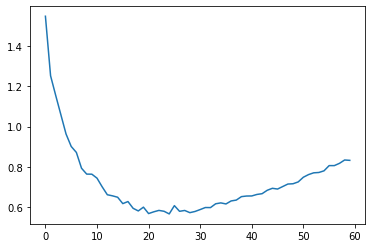

In [382]:
net = Net()
LOSS = training()
val()

In [361]:
LOSS

[tensor(1.5984, grad_fn=<NllLossBackward>),
 tensor(1.2555, grad_fn=<NllLossBackward>),
 tensor(1.0981, grad_fn=<NllLossBackward>),
 tensor(1.0262, grad_fn=<NllLossBackward>),
 tensor(0.9311, grad_fn=<NllLossBackward>),
 tensor(0.8771, grad_fn=<NllLossBackward>),
 tensor(0.8391, grad_fn=<NllLossBackward>),
 tensor(0.7973, grad_fn=<NllLossBackward>),
 tensor(0.7456, grad_fn=<NllLossBackward>),
 tensor(0.7269, grad_fn=<NllLossBackward>),
 tensor(0.7003, grad_fn=<NllLossBackward>),
 tensor(0.6746, grad_fn=<NllLossBackward>),
 tensor(0.6673, grad_fn=<NllLossBackward>),
 tensor(0.6368, grad_fn=<NllLossBackward>),
 tensor(0.6249, grad_fn=<NllLossBackward>),
 tensor(0.6067, grad_fn=<NllLossBackward>),
 tensor(0.6222, grad_fn=<NllLossBackward>),
 tensor(0.5900, grad_fn=<NllLossBackward>),
 tensor(0.5908, grad_fn=<NllLossBackward>),
 tensor(0.5775, grad_fn=<NllLossBackward>),
 tensor(0.5876, grad_fn=<NllLossBackward>),
 tensor(0.5794, grad_fn=<NllLossBackward>),
 tensor(0.5576, grad_fn=<NllLoss

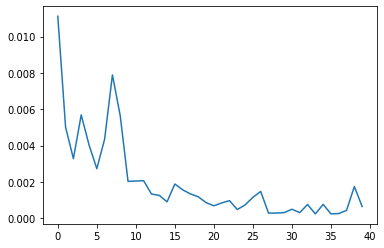

In [325]:
plt.plot(LOSS[60:100])

In [42]:
predictions = net(test_X)

In [43]:
final_predictions = []
for i in range(len(predictions)):
    final_predictions.append(torch.argmax(predictions[i]))

In [44]:
pred = np.array(final_predictions)

In [45]:
predictions = pd.DataFrame(pred,columns=['Label'])

In [46]:
predictions = pd.concat([pd.DataFrame({'ImageId':np.arange(1,28001,1)}),predictions],axis=1)

In [47]:
predictions.to_csv('../Digit/Data/submission2.csv',index=False)

In [101]:
y = torch.cat((torch.arange(100),torch.arange(-5,0)))

In [104]:
torch.unique(y,sorted = True)

tensor([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
y